In [569]:
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.optim as optim
import torch.nn.functional as F
# torhc dataset
from torch.utils.data import Dataset, DataLoader

# train test split
from sklearn.model_selection import train_test_split

from torch.optim.lr_scheduler import ReduceLROnPlateau

import pandas as pd
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE

#import summary for models
from torchsummary import summary

import numpy as np
from sklearn.preprocessing import StandardScaler, OrdinalEncoder

In [570]:
all_data = pd.read_csv("../Data/Train_and_Validate_EEG.csv", index_col=0).drop("Unnamed: 122",axis=1)
data = all_data.drop(['sex','eeg.date','education','specific.disorder'], axis=1).dropna(axis=0)

# Encode disorders
encoder = OrdinalEncoder()
data[['main.disorder']] = encoder.fit_transform(data[['main.disorder']])

X = data.drop(['main.disorder'], axis=1).dropna(axis=0)
y = data['main.disorder']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [571]:
bands = ['gamma', 'highbeta', 'beta', 'alpha', 'theta', 'delta']
bands2 = ['F.gamma', 'E.highbeta', 'D.beta', 'C.alpha', 'B.theta', 'A.delta']

# Separate column names based on whether they are PSD or coherence
AB_per_band = {}
AB_cols = []
COH_per_band = {}
COH_cols = []

for band in bands:
    AB_per_band[band] = []
    COH_per_band[band] = []

for col_name in X_train.drop(['age','IQ'], axis=1).columns:
    col_split = col_name.split('.')
    if col_split[0] == 'AB':
        AB_per_band[col_split[2]].append(col_name)
        AB_cols.append(col_name)
    else:
        COH_per_band[col_split[2]].append(col_name)
        COH_cols.append(col_name)

In [572]:
# Get all electrode names
electrodes = set()
for col in COH_cols:
    col_split = col.split('.')
    # elec1 = col_split[4]
    electrodes.add(col_split[3]+'.'+col_split[4])
    # elec2 = col_split[6]
    electrodes.add(col_split[5]+'.'+col_split[6])

electrodes = list(electrodes)
len(electrodes)

19

## data preprocessing
coherence data shape = [num individuals, frequency bands, electrodes, electrodes]
PSD data shape = [num individuals, frequency bands, electrodes]

In [573]:
num_samples = X_train.shape[0]
num_nodes = len(electrodes)
num_bands = len(bands)

In [574]:
def getCoherenceStacked(coherence):
    adj_tensors = []

    # for each individual
    for i in range(coherence.shape[0]):
        indiv_tensors = []

        # for each band
        for band_idx in range(len(bands2)):
            # adjacency matrix electrodes x electrodes
            adj_matrix = np.zeros([len(electrodes),len(electrodes)])

            for elec1 in range(len(electrodes)):
                for elec2 in range(elec1+1, len(electrodes)):
                    col_name = 'COH.'+bands2[band_idx]+'.'+electrodes[elec1]+'.'+electrodes[elec2]
                    if col_name in coherence.columns:
                        adj_matrix[elec1][elec2] = coherence.iloc[i,:][col_name] #individual's row, then get value
                    else:
                        col_name = 'COH.'+bands2[band_idx]+'.'+electrodes[elec2]+'.'+electrodes[elec1]
                        adj_matrix[elec1][elec2] = coherence.iloc[i,:][col_name] #individual's row, then get value
            indiv_tensors.append(torch.from_numpy(adj_matrix).fill_diagonal_(1.0))

        adj_tensors.append(torch.stack(indiv_tensors))

    adj_matrices = torch.stack(adj_tensors)
    # print(adj_matrices.shape)
    adj_matrices = (adj_matrices + adj_matrices.transpose(2, 3)) / 2  # Ensure symmetry
    print(adj_matrices.shape)
    return adj_matrices

In [575]:
def getPSDStacked(psd):
    psd_tensors = []
    # for each individual
    for i in range(psd.shape[0]):
        psd_mat = np.zeros([len(electrodes),len(bands2)])

        # for each band
        for band_idx in range(len(bands2)):
            for elec1 in range(len(electrodes)):
                col_name = 'AB.'+bands2[band_idx]+'.'+electrodes[elec1]
                psd_mat[elec1][band_idx] = psd.iloc[i,:][col_name] #individual's row, then get value

        psd_tensors.append(torch.from_numpy(psd_mat))

    node_features = torch.stack(psd_tensors)
    print(node_features.shape)
    return node_features

In [576]:
node_features = getPSDStacked(X_train).transpose(1,2)
node_features_val = getPSDStacked(X_val).transpose(1,2)

torch.Size([672, 19, 6])
torch.Size([168, 19, 6])


In [577]:
adj_matrices = getCoherenceStacked(X_train)
adj_matrices_val = getCoherenceStacked(X_val)

# Populating diagonals
for i in range(adj_matrices.shape[2]):
  adj_matrices[:,:,i,i] = node_features[:,:,i]
  adj_matrices_val[:,:,i,i] = node_features_val[:,:,i]

torch.Size([672, 6, 19, 19])
torch.Size([168, 6, 19, 19])


In [578]:
# create data loaders from adj_matrices and node_features
class EEGDataset(Dataset):
    def __init__(self, adj_matrices, node_features, labels):
        self.adj_matrices = torch.tensor(adj_matrices, dtype=torch.float32)
        self.node_features = torch.tensor(node_features, dtype=torch.float32)
        self.labels = torch.tensor(labels.to_list(), dtype=torch.long)
        if len(self.adj_matrices) != len(self.labels):
            raise ValueError("Adjacency matrices and labels must have the same length: {} != {}".format(len(self.adj_matrices), len(self.labels)))
        if len(self.node_features) != len(self.labels):
            raise ValueError("Node features and labels must have the same length: {} != {}".format(len(self.node_features), len(self.labels)))

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return (self.node_features[idx], self.adj_matrices[idx]), self.labels[idx]

print(adj_matrices.shape)
train_dataset = EEGDataset(adj_matrices, node_features, y_train)
val_dataset = EEGDataset(adj_matrices_val, node_features_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

torch.Size([672, 6, 19, 19])


/var/folders/pz/bsrlw1051zq7wv21r5cq1y280000gn/T/ipykernel_88615/3968449242.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.adj_matrices = torch.tensor(adj_matrices, dtype=torch.float32)
/var/folders/pz/bsrlw1051zq7wv21r5cq1y280000gn/T/ipykernel_88615/3968449242.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.node_features = torch.tensor(node_features, dtype=torch.float32)


## modeling

In [579]:
class EEGClassifier(nn.Module):
    def __init__(self, dropout=0.15):
        super(EEGClassifier, self).__init__()

        # Define convolutional 2d layers

        # 1, 19, 19
        self.conv1 = nn.ModuleList([
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(4, 4))
            for _ in range(6)
        ])
        # 8, 16, 16
        self.maxpools1 = nn.ModuleList([nn.MaxPool2d(kernel_size=(2, 2)) for _ in range(6)])
        # 8, 8, 8

        self.conv2 = nn.ModuleList([
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3))
            for _ in range(6)
        ])
        # 16, 6, 6
        self.maxpools2 = nn.ModuleList([nn.MaxPool2d(kernel_size=(2, 2)) for _ in range(6)])
        self.batchnorms = nn.ModuleList([nn.BatchNorm2d(32) for _ in range(6)])
        # 16, 3, 3
        self.flatten = nn.Flatten()
        # 144
        self.coh_linears1 = nn.ModuleList([
            nn.Linear(288, 128)
            for _ in range(6)
        ])
        self.coh_linears2 = nn.ModuleList([
            nn.Linear(128, 64)
            for _ in range(6)
        ])
        self.psd_convs1 = nn.ModuleList([
            # 19 x 1 -> 17 x 8
            nn.Conv1d(in_channels=1, out_channels=8, kernel_size=3) for _ in range(6)
        ])
        self.psd_convs2 = nn.ModuleList([
            # 17 x 8 -> 6 x 32
            nn.Conv1d(in_channels=8, out_channels=32, kernel_size=5, stride=2) for _ in range(6)
        ])
        # self.psd_convs3 = nn.ModuleList([
        #     # 6 x 32 -> 5 x 64
        #     nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3) for _ in range(6)
        # ])
        self.psd_linears = nn.ModuleList([
            nn.Linear(7 * 32, 64)
            for _ in range(6)
        ])
        self.band_linears = nn.ModuleList([
            nn.Linear(128, 64)
            for _ in range(6)
        ])

        self.bn1 = nn.BatchNorm1d(64 * 6)

        # Define linear layers
        self.layer1 = nn.Linear(64 * 6, 128)

        self.bn2 = nn.BatchNorm1d(128)

        self.layer2 = nn.Linear(128, 32)

        self.bn3 = nn.BatchNorm1d(32)

        self.layer3 = nn.Linear(32, 7)

        self.gelu = nn.GELU()

        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x_psd, x_adj):
        # x_psd is the PSD data, 6 x 19 tensor
        # x_adj is the adjacency matrix data, 6 x 19 x 19 tensor

        # Process psds
        x_psds = [None for _ in range(6)]
        for i in range(6):
            x_psds[i] = self.psd_convs1[i](x_psd[:,i].unsqueeze(1))
            x_psds[i] = self.gelu(x_psds[i])
            x_psds[i] = self.psd_convs2[i](x_psds[i])
            x_psds[i] = self.gelu(x_psds[i])
            x_psds[i] = self.dropout(x_psds[i])
            # x_psds[i] = self.psd_convs3[i](x_psds[i])
            # x_psds[i] = self.gelu(x_psds[i])
            x_psds[i] = self.flatten(x_psds[i])
            x_psds[i] = self.psd_linears[i](x_psds[i])
            x_psds[i] = self.gelu(x_psds[i])
            x_psds[i] = self.dropout(x_psds[i])

        # Process adjacency matrices
        x_adjs = [None for _ in range(6)]
        for i in range(6):
            x_adjs[i] = self.conv1[i](x_adj[:,i].unsqueeze(1))
            x_adjs[i] = self.maxpools1[i](x_adjs[i])
            x_adjs[i] = self.conv2[i](x_adjs[i])
            x_adjs[i] = self.maxpools2[i](x_adjs[i])
            x_adjs[i] = self.gelu(x_adjs[i])
            x_adjs[i] = self.batchnorms[i](x_adjs[i])
            x_adjs[i] = self.flatten(x_adjs[i])
            x_adjs[i] = self.coh_linears1[i](x_adjs[i])
            x_adjs[i] = self.gelu(x_adjs[i])
            x_adjs[i] = self.coh_linears2[i](x_adjs[i])
            x_adjs[i] = self.gelu(x_adjs[i])
            x_adjs[i] = self.dropout(x_adjs[i])

        x_bands = [None for _ in range(6)]
        for i in range(6):
            x_bands[i] = torch.cat([x_psds[i], x_adjs[i]], axis=1)
            x_bands[i] = self.band_linears[i](x_bands[i])
            x_bands[i] = self.gelu(x_bands[i])

        # Concatenate the two
        x = torch.cat(x_bands, axis=1)

        x = self.bn1(x)

        # Apply more linear layers
        x = self.layer1(x)
        x = self.gelu(x)
        x = self.dropout(x)

        x = self.layer2(x)
        x = self.gelu(x)
        x = self.dropout(x)

        x = self.layer3(x)

        return x

In [580]:
# Initialize the model
model = EEGClassifier()
# Print the model
print(model)
# how many parameters?
pytorch_total_params = sum(p.numel() for p in model.parameters())
print(pytorch_total_params)

EEGClassifier(
  (conv1): ModuleList(
    (0-5): 6 x Conv2d(1, 16, kernel_size=(4, 4), stride=(1, 1))
  )
  (maxpools1): ModuleList(
    (0-5): 6 x MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): ModuleList(
    (0-5): 6 x Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  )
  (maxpools2): ModuleList(
    (0-5): 6 x MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (batchnorms): ModuleList(
    (0-5): 6 x BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (coh_linears1): ModuleList(
    (0-5): 6 x Linear(in_features=288, out_features=128, bias=True)
  )
  (coh_linears2): ModuleList(
    (0-5): 6 x Linear(in_features=128, out_features=64, bias=True)
  )
  (psd_convs1): ModuleList(
    (0-5): 6 x Conv1d(1, 8, kernel_size=(3,), stride=(1,))
  )
  (psd_convs2): ModuleList(
    (0-5): 6 x Conv1d(8, 32, kernel_size=(5,)

In [581]:
# Pass through random data
x_psd = torch.randn(4, 6, 19)
x_adj = torch.randn(4, 6, 19, 19)
output = model(x_psd, x_adj)
print(output)

tensor([[ 0.2825,  0.0351,  0.1903,  0.0066, -0.0981, -0.0235, -0.0127],
        [ 0.0457,  0.2287,  0.0686,  0.1711, -0.1669,  0.1261,  0.0733],
        [ 0.1512, -0.1208,  0.2135,  0.0678, -0.1926,  0.0658,  0.1847],
        [ 0.1696, -0.0861,  0.1676,  0.1495, -0.3718, -0.1137,  0.0756]],
       grad_fn=<AddmmBackward0>)


In [582]:
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(),
                       lr=0.00003,
                       weight_decay=1e-5)

scheduler = ReduceLROnPlateau(optimizer,
                              mode='min',
                              factor = 0.1,
                              patience = 3,
                              min_lr = 1e-5,
                              verbose = True)

/Users/hamsterlord/.pyenv/versions/3.10.4/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


In [583]:
print(len(train_dataset))
for data in train_loader:
    (adj_matrices, node_features), labels = data
    print(adj_matrices.shape)
    print(node_features.shape)
    print(labels.shape)
    break

672
torch.Size([32, 6, 19])
torch.Size([32, 6, 19, 19])
torch.Size([32])


In [584]:
best_loss = np.inf
patience = 20
min_delta = 0.01
early_stop_counter = 0

train_losses = []
train_accs = []
val_losses = []
val_accs = []
final_epoch = 0

num_epochs = 500

for epoch in range(num_epochs):

    # train
    model.train()
    running_loss = 0.
    running_accuracy = 0.

    for data in train_loader:
        inputs, labels = data

        optimizer.zero_grad()  # zero gradients

        outputs = model.forward(*inputs)  # input net

        labels = labels.long()

        loss = criterion(outputs, labels)
        loss.backward()

        outputs = F.softmax(outputs, dim=1)
        top_p, top_class = outputs.topk(k=1, dim=1)

        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        accuracy = (predicted == labels).float().sum()
        running_accuracy += accuracy.item()

    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = running_accuracy / len(train_dataset)
    train_accs.append(epoch_accuracy)

    if epoch % 5 == 0:
        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}, Acc: {epoch_accuracy:.4f}")
    train_losses.append(epoch_loss)

    # val
    model.eval()
    val_loss = 0.0
    val_accuracy = 0.0
    correct = total = 0

    with torch.no_grad():
        for data in val_loader:
            inputs, labels = data

            outputs = model(*inputs)

            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)

            accuracy = (predicted == labels).float().mean()
            val_accuracy += accuracy.item()

    val_loss /= len(val_loader)
    val_accuracy /= len(val_loader)

    if epoch % 5 == 0:
        print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}\n")
    val_losses.append(val_loss)
    val_accs.append(val_accuracy)


    # Early stopping
    if val_loss < best_loss - min_delta:
        best_loss = val_loss
        early_stop_counter = 0
        #best_model_state = model.state_dict()
    else:
        early_stop_counter += 1

    # if early_stop_counter >= patience:
    #     print(f"Early stopping at epoch {epoch+1}.")
    #     final_epoch = epoch+1
    #     #model.load_state_dict(best_model_state)
    #     break

    scheduler.step(val_loss)

Epoch [1/500], Loss: 1.9228, Acc: 0.1756
Validation Loss: 1.9071, Validation Accuracy: 0.1719

Epoch [6/500], Loss: 1.9186, Acc: 0.1905
Validation Loss: 1.9038, Validation Accuracy: 0.2240

Epoch [11/500], Loss: 1.9102, Acc: 0.2083
Validation Loss: 1.9021, Validation Accuracy: 0.2344

Epoch [16/500], Loss: 1.9028, Acc: 0.2173
Validation Loss: 1.8993, Validation Accuracy: 0.2292

Epoch [21/500], Loss: 1.8987, Acc: 0.2143
Validation Loss: 1.8949, Validation Accuracy: 0.2500

Epoch [26/500], Loss: 1.8989, Acc: 0.2143
Validation Loss: 1.8915, Validation Accuracy: 0.2448

Epoch [31/500], Loss: 1.8807, Acc: 0.2812
Validation Loss: 1.8895, Validation Accuracy: 0.2500

Epoch [36/500], Loss: 1.8850, Acc: 0.2649
Validation Loss: 1.8858, Validation Accuracy: 0.2812

Epoch [41/500], Loss: 1.8752, Acc: 0.2500
Validation Loss: 1.8831, Validation Accuracy: 0.2917

Epoch [46/500], Loss: 1.8691, Acc: 0.2798
Validation Loss: 1.8789, Validation Accuracy: 0.3073

Epoch [51/500], Loss: 1.8583, Acc: 0.2932


KeyboardInterrupt: 

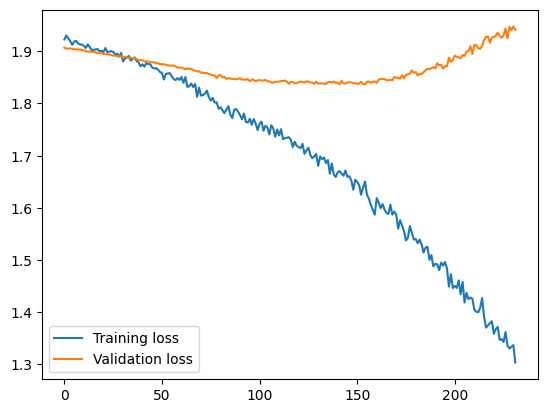

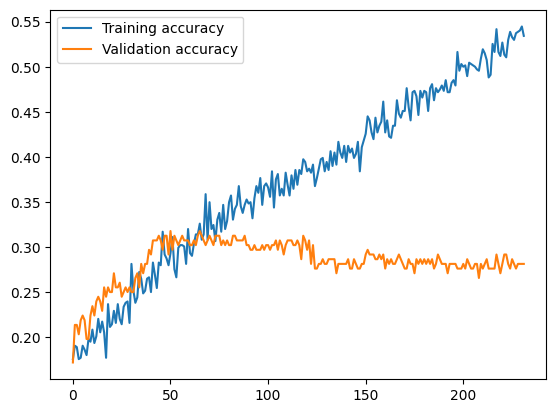

In [585]:
# plot accuracy and loss
import matplotlib.pyplot as plt

plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend()
plt.show()

plt.plot(train_accs, label='Training accuracy')
plt.plot(val_accs, label='Validation accuracy')
plt.legend()
plt.show()

In [586]:
max(val_accs)

0.3177083333333333